# 1D St-Venant Kinematic River Flow Solver (Object-Oriented)

This notebook provides an object-oriented implementation of the 1D kinematic wave approximation for river flow using the Firedrake finite element library.

## Physical Model
- **Conservation Law**: ∂A/∂t + ∂Q/∂s = 0 (cross-sectional area conservation)
- **Manning's Equation**: Q = (√|slope|/Cm) × A^(5/3) / P^(2/3)
- **Channel Profiles**: Simple rectangular (nRP=0) or compound channel (nRP=1)

## Numerical Method
- **Discretization**: DG0 (piecewise constant) finite volume method
- **Flux Scheme**: Godunov upwind flux based on wave speed dF/dA
- **Time Integration**: Forward Euler with CFL condition

In [1]:
# Import required libraries
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import plotly.express as px
from typing import Tuple, Optional, Callable
from dataclasses import dataclass

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


## River Class

Encapsulates the river geometry, physical parameters, and mesh.

In [2]:
@dataclass
class RiverParameters:
    """Physical and geometric parameters for the river channel."""
    # Domain
    length: float = 5000.0          # Channel length (m)
    num_cells: int = 2500           # Number of mesh cells
    
    # Width parameters
    w0: float = 30.0                # Initial width (m)
    w1: float = 30.0                # Intermediate width (m)
    w2: float = 30.0                # Final width (m)
    xa: float = 0.0                 # Start of first transition (m)
    xb: float = 2500.0              # End of first transition (m)
    xc: float = 2500.0              # Start of second transition (m)
    xd: float = 5000.0              # End of second transition (m)
    k1: float = 1.0                 # Steepness of first transition
    k2: float = 1.0                 # Steepness of second transition
    
    # Profile type (0: rectangular, 1: compound)
    profile_type: int = 1
    
    # Compound channel parameters (nRP=1)
    wb: float = 20.0                # Narrow channel width (m)
    hb: float = 5.0                 # Narrow channel height (m)
    
    # Physical parameters
    slope: float = 1.0/1000.0       # Channel slope
    manning: float = 0.025          # Manning's roughness coefficient
    
    # Initial condition
    initial_depth: float = 0.05     # Initial water depth (m)

    def copy(self):
        """Create a copy of the river parameters."""
        return RiverParameters(**vars(self))


class River:
    """Represents a 1D river channel with variable width."""
    
    def __init__(self, params: RiverParameters):
        """Initialize river with given parameters."""
        self.params = params
        
        # Create mesh
        self.mesh = fd.IntervalMesh(params.num_cells, params.length)
        
        # Derived parameters
        self.sqrt_slope = np.sqrt(np.abs(params.slope))
        self.Ab = params.wb * params.hb  # Compound channel transition area
        
        # Firedrake constants for compound channel
        self.Ab_const = fd.Constant(self.Ab)
        self.wb_const = fd.Constant(params.wb)
        self.hb_const = fd.Constant(params.hb)
        
    def width(self, s: float) -> float:
        """Compute channel width at position s (Python function)."""
        p = self.params
        
        # First transition (xa to xb)
        if p.xa < p.xb:
            w_mid = p.w0 + 0.5*(p.w1 - p.w0)*(1.0 + np.tanh(p.k1*(s - 0.5*(p.xa + p.xb))))
        else:
            w_mid = p.w0
        
        # Second transition (xc to xd)
        if p.xc < p.xd:
            w_final = w_mid + 0.5*(p.w2 - p.w1)*(1.0 + np.tanh(p.k2*(s - 0.5*(p.xc + p.xd))))
        else:
            w_final = w_mid
        
        return w_final
    
    def width_ufl(self, x):
        """Compute channel width as UFL expression for Firedrake."""
        p = self.params
        
        # First transition
        if p.xa < p.xb:
            w_mid = p.w0 + 0.5*(p.w1 - p.w0)*(1.0 + fd.tanh(p.k1*(x - 0.5*(p.xa + p.xb))))
        else:
            w_mid = p.w0
        
        # Second transition
        if p.xc < p.xd:
            w_final = w_mid + 0.5*(p.w2 - p.w1)*(1.0 + fd.tanh(p.k2*(x - 0.5*(p.xc + p.xd))))
        else:
            w_final = w_mid
        
        return w_final
    
    def manning_flux(self, A, w):
        """Compute Manning flux Q = (√|slope|/Cm) * A^(5/3) / P^(2/3)."""
        p = self.params
        
        if p.profile_type == 0:
            # Simple rectangular: P = w + 2*A/w
            perimeter = w + 2.0*A/w
            flux = self.sqrt_slope * A**(5/3) / perimeter**(2/3) / p.manning
        else:
            # Compound channel: conditional perimeter
            P_narrow = self.wb_const + 2.0*A/self.wb_const
            P_compound = self.wb_const + 2*self.hb_const + w - self.wb_const + 2.0*(A - self.Ab_const)/w
            perimeter = fd.conditional(A < self.Ab_const, P_narrow, P_compound)
            flux = self.sqrt_slope * A**(5/3) / perimeter**(2/3) / p.manning
        
        return flux
    
    def wave_speed(self, A, A_avg, w, at_boundary: bool = False):
        """Compute wave speed dF/dA for upwind flux selection."""
        p = self.params
        A_eval = A if at_boundary else A_avg
        factor = self.sqrt_slope / (3.0 * p.manning)
        
        if p.profile_type == 0:
            # Simple rectangular
            numerator = 5*w + 6*A_eval/w
            denominator = (w + 2.0*A_eval/w)**(5/3)
            speed = factor * A_eval**(2/3) * numerator / denominator
        else:
            # Compound channel
            # Narrow section
            num_narrow = 5*self.wb_const + 6*A_eval/self.wb_const
            den_narrow = (self.wb_const + 2.0*A_eval/self.wb_const)**(5/3)
            speed_narrow = num_narrow / den_narrow
            
            # Compound section
            num_compound = 5*(self.wb_const + 2*self.hb_const + w - self.wb_const - 2*self.Ab_const/w) + 6*A_eval/w
            den_compound = (self.wb_const + 2*self.hb_const + w - self.wb_const + 2*(A_eval - self.Ab_const)/w)**(5/3)
            speed_compound = num_compound / den_compound
            
            speed = factor * A_eval**(2/3) * fd.conditional(A_eval < self.Ab_const, speed_narrow, speed_compound)
        
        return speed
    
    def depth_from_area(self, A, w):
        """Compute water depth from cross-sectional area."""
        if self.params.profile_type == 0:
            # Simple rectangular: h = A/w
            return A / w
        else:
            # Compound channel: h = A/wb if A < Ab, else h = hb + (A-Ab)/w
            h_narrow = A / self.wb_const
            h_compound = self.hb_const + (A - self.Ab_const) / w
            return fd.conditional(A < self.Ab_const, h_narrow, h_compound)

## Solver Class

Implements the DG0 finite volume solver for the kinematic wave equation.

In [3]:
@dataclass
class SolverParameters:
    """Time integration and boundary condition parameters."""
    # Time parameters
    t_end: float = 60.0             # End time (s)
    CFL: float = 0.5                # CFL number

    # Physics Parameters
    g: float = 9.81                 # Gravitational acceleration (m/s²)
    
    # Inflow pulse parameters
    Q_max: float = 250.0            # Maximum pulse amplitude (m³/s)
    t_max: float = 20.0             # Time of pulse peak (s)
    gamma: float = 1.0/9.0          # Pulse decay rate
    
    # Output parameters
    output_interval: float = 10.0   # Time between outputs (s)
    save_time: Optional[float] = None  # Specific time to save solution (s)
    
    def copy(self):
        """Create a copy of the solver parameters."""
        return SolverParameters(**vars(self))

class KinematicWaveSolver:
    """Finite volume solver for 1D kinematic wave equation."""
    
    def __init__(self, river: River, solver_params: SolverParameters):
        """Initialize solver with river and solver parameters."""
        self.river = river
        self.riverPlotter = RiverPlotter(river)
        self.params = solver_params
        
        # Function spaces
        self.DG0 = fd.FunctionSpace(river.mesh, "DG", 0)
        self.CG1 = fd.FunctionSpace(river.mesh, "CG", 1)
        
        # Solution variables
        self.A0 = fd.Function(self.DG0, name="Area_n")      # Area at time n
        self.A1 = fd.Function(self.DG0, name="Area_n+1")    # Area at time n+1
        
        # Width function
        x = fd.SpatialCoordinate(river.mesh)[0]
        self.x_coord = x
        self.width_expr = river.width_ufl(x)
        self.width_func = fd.Function(self.CG1, name="Width")
        self.width_func.interpolate(self.width_expr)
        
        # Time tracking
        self.t = 0.0
        self.nt = 0
        dxx = river.params.length / river.params.num_cells
        # Approzimate wave speed sqrt(g*H)
        c00 = np.sqrt(solver_params.g * river.params.initial_depth)
        self.dt = solver_params.CFL * dxx / np.amax(c00)  # Initial guess

        # Inflow boundary values
        self.A_left = fd.Constant(0.0)
        self.Q_left = fd.Constant(0.0)
        
        # Setup variational problem
        self._setup_variational_problem()
        
        
        # History for plotting
        self.time_history = []
        self.inflow_history = []

        if self.params.save_time is not None:
            self.save_time = self.params.save_time
        else:
            self.save_time = self.params.t_end / 2
        # Columns of position, width, depth, discharge at save time
        self.data_at_save: Optional[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]] = None
    
    def _setup_variational_problem(self):
        """Set up the weak formulation and linear solver."""
        # Test and trial functions
        A_test = fd.TestFunction(self.DG0)
        A_trial = fd.TrialFunction(self.DG0)
        
        # Mass matrix
        self.mass_matrix = A_test * A_trial * fd.dx
        
        # Facet normal and average
        n = fd.FacetNormal(self.river.mesh)
        A_avg = 0.5 * (self.A0('+') + self.A0('-'))
        
        # Flux terms
        w = self.width_expr
        
        # Manning flux at interfaces
        Q_minus = self.river.manning_flux(self.A0('-'), w)
        Q_plus = self.river.manning_flux(self.A0('+'), w)
        
        # Wave speed for upwind selection
        wave_speed = self.river.wave_speed(self.A0, A_avg, w, at_boundary=False)
        wave_speed_bnd = self.river.wave_speed(self.A0, self.A0, w, at_boundary=True)
        
        # Upwind flux selection
        Q_upwind = fd.conditional(wave_speed * n[0]('+') > 0, Q_plus, Q_minus)
        
        # Boundary fluxes
        Q_left_bnd = fd.conditional(wave_speed_bnd * n[0] > 0, self.Q_left, self.Q_left)
        Q_right_bnd = fd.conditional(wave_speed_bnd * n[0] > 0, 
                                      self.river.manning_flux(self.A0, w),
                                      self.river.manning_flux(self.A0, w))
        
        # RHS: Forward Euler time stepping
        dt_const = fd.Constant(self.dt)
        rhs = A_test * self.A0 * fd.dx
        rhs -= dt_const * Q_upwind * n[0]('+') * (A_test('+') - A_test('-')) * fd.dS
        rhs -= dt_const * Q_left_bnd * n[0] * A_test * fd.ds(1)   # Left boundary
        rhs -= dt_const * Q_right_bnd * n[0] * A_test * fd.ds(2)  # Right boundary
        
        # Linear variational problem
        problem = fd.LinearVariationalProblem(self.mass_matrix, rhs, self.A1)
        
        # Solver with Jacobi preconditioner
        solver_params = {"ksp_type": "preonly", "pc_type": "jacobi"}
        self.solver = fd.LinearVariationalSolver(problem, solver_parameters=solver_params)
    
    def set_initial_condition(self, depth: Optional[float] = None):
        """Set initial uniform depth condition."""
        if depth is None:
            depth = self.river.params.initial_depth
        
        p = self.river.params
        
        if p.profile_type == 0:
            # Simple rectangular: A = h * w(x)
            self.A0.interpolate(depth * self.width_expr)
        else:
            # Compound channel: A = h * wb (assumes h < hb)
            self.A0.interpolate(depth * self.river.wb_const)
        
        # Set initial boundary condition
        w0 = self.river.width(0.0)
        if p.profile_type == 0:
            A_left_val = depth * w0
        else:
            A_left_val = depth * p.wb
        
        self.A_left.assign(A_left_val)
        
        # Compute initial discharge
        Q_left_val = self._compute_inflow_discharge(A_left_val, w0)
        self.Q_left.assign(Q_left_val)
        
        # Reset time
        self.t = 0.0
        self.nt = 0
        self.time_history = []
        self.inflow_history = []
    
    def _compute_inflow_discharge(self, A_val: float, w_val: float) -> float:
        """Compute discharge at inflow boundary."""
        p = self.river.params
        
        if p.profile_type == 0:
            # Simple rectangular
            P = w_val + 2.0*A_val/w_val
            Q = self.river.sqrt_slope * A_val**(5/3) / P**(2/3) / p.manning
        else:
            # Compound channel
            if A_val < self.river.Ab:
                P = p.wb + 2.0*A_val/p.wb
                Q = self.river.sqrt_slope * A_val**(5/3) / P**(2/3) / p.manning
            else:
                P = p.wb + 2*p.hb + w_val - p.wb + 2.0*(A_val - self.river.Ab)/w_val
                Q = self.river.sqrt_slope * A_val**(5/3) / P**(2/3) / p.manning
        
        return Q
    
    def update_boundary_condition(self):
        """Update inflow boundary condition with Gaussian pulse."""
        # Base flow
        w0 = self.river.width(0.0)
        A_left_val = float(self.A_left)
        Q_base = self._compute_inflow_discharge(A_left_val, w0)
        
        # Add Gaussian pulse
        pulse = self.params.Q_max * np.exp(-self.params.gamma * (self.t - self.params.t_max)**2)
        Q_total = Q_base + pulse
        
        self.Q_left.assign(Q_total)
        
        # Store for plotting
        self.time_history.append(self.t)
        self.inflow_history.append(Q_total)
    
    def step(self):
        """Advance solution by one time step."""
        # Update boundary condition
        self.update_boundary_condition()
        
        # Solve linear system
        self.solver.solve()
        
        # Update solution
        self.A0.assign(self.A1)
        
        # Increment time
        self.t += self.dt
        self.nt += 1
    
    def solve(self, callback: Optional[Callable[[float, int], None]] = None):
        """Run simulation until end time."""
        print(f"Starting simulation: dt={self.dt}s, t_end={self.params.t_end}s")
        tic = time.time()
        
        next_output = self.params.output_interval
        
        while self.t <= self.params.t_end:
            # Save if within dt of save_time
            if self.data_at_save is None and self.t + self.dt >= self.save_time - 1e-10:
                print("Saving solution at t =", self.save_time)
                x_vals, width_vals, depth_vals, discharge_vals = self.get_solution_arrays()
                self.data_at_save = (x_vals, width_vals, depth_vals, discharge_vals)
            
            self.step()
            
            # Call user callback if provided
            if callback is not None and self.t >= next_output - 1e-10:
                callback(self.t, self.nt)
                next_output += self.params.output_interval
        
        elapsed = time.time() - tic
        print(f"Simulation complete: {self.nt} steps in {elapsed:.2f}s ({elapsed/60:.2f} min)")
    
    def get_solution_arrays(self, nx: int = 1000) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Evaluate solution on uniform grid for plotting.
        
        Returns:
            x_vals: spatial coordinates (m)
            width_vals: channel width (m)
            depth_vals: water depth (m)
            discharge_vals: discharge (m^3/s)
        """
        # Create evaluation points
        x_vals = np.linspace(1e-6, self.river.params.length - 1e-6, nx)
        
        # Evaluate width
        width_vals = np.array([self.width_func.at(x) for x in x_vals])
        
        # Compute discharge and depth
        Q_func = fd.Function(self.DG0)
        h_func = fd.Function(self.DG0)
        
        Q_func.interpolate(self.river.manning_flux(self.A0, self.width_expr))
        h_func.interpolate(self.river.depth_from_area(self.A0, self.width_expr))
        
        discharge_vals = np.array([Q_func.at(x) for x in x_vals])
        depth_vals = np.array([h_func.at(x) for x in x_vals])
        
        return x_vals, width_vals, depth_vals, discharge_vals
    
    def discharge_at_time(self, time: float, nx: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
        """Get discharge profile at specified time."""
        # Get solution
        x_vals, width_vals, depth_vals, discharge_vals = self.get_solution_arrays(nx)

        
        return x_vals, discharge_vals


## Plotting Utilities

Clean plotting functions for visualizing initial conditions and solution evolution.

In [4]:
class RiverPlotter:
    """Handles plotting for river flow simulations."""
    
    def __init__(self, solver: KinematicWaveSolver, figsize: Tuple[int, int] = (12, 8)):
        """Initialize plotter with solver instance."""
        self.solver = solver
        self.figsize = figsize
        self.profile_fig = None
        self.profile_axes = None
        
    def create_profile_figure(self):
        """Create figure with 3 subplots for depth, width, and discharge."""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=self.figsize, sharex=True)
        
        ax1.set_ylabel(r'$h(s,t)$ (m)', fontsize=14)
        ax1.grid(True, alpha=0.3)
        
        ax2.set_ylabel(r'$w(s)$ (m)', fontsize=14)
        ax2.grid(True, alpha=0.3)
        
        ax3.set_xlabel(r'$s$ (m)', fontsize=14)
        ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s)', fontsize=14)
        ax3.grid(True, alpha=0.3)
        
        self.profile_fig = fig
        self.profile_axes = (ax1, ax2, ax3)
        
        return fig, (ax1, ax2, ax3)
    
    def plot_initial_condition(self, nx: int = 1000, show: bool = True):
        """Plot initial condition."""
        if self.profile_fig is None:
            self.create_profile_figure()
        
        ax1, ax2, ax3 = self.profile_axes
        
        # Get solution arrays
        x_vals, width_vals, depth_vals, discharge_vals = self.solver.get_solution_arrays(nx)
        
        # Plot initial condition
        ax1.plot(x_vals, depth_vals, '--c', linewidth=2, label=f't={self.solver.t:.1f}s (initial)')
        ax2.plot(x_vals, width_vals, '-k', linewidth=1.5, label='Channel width')
        ax3.plot(x_vals, discharge_vals, '--c', linewidth=2, label=f't={self.solver.t:.1f}s (initial)')
        
        ax1.legend(loc='best')
        ax2.legend(loc='best')
        ax3.legend(loc='best')
        
        if show:
            plt.tight_layout()
            plt.show()
        
        return self.profile_fig
    
    def plot_solution_at_time(self, nx: int = 1000, color: str = 'r', 
                             linestyle: str = '-.', linewidth: float = 1.5,
                             label: Optional[str] = None, show: bool = False):
        """Plot solution at current time."""
        if self.profile_fig is None:
            self.create_profile_figure()
        
        ax1, ax2, ax3 = self.profile_axes
        
        # Get solution arrays
        print(f"Plotting solution at t={self.solver.t:.2f}s")
        x_vals, width_vals, depth_vals, discharge_vals = self.solver.get_solution_arrays(nx)
        
        # Default label
        if label is None:
            label = f't={self.solver.t:.1f}s'
        
        # Plot solution
        ax1.plot(x_vals, depth_vals, linestyle=linestyle, color=color, 
                linewidth=linewidth, label=label)
        ax3.plot(x_vals, discharge_vals, linestyle=linestyle, color=color, 
                linewidth=linewidth, label=label)
        
        ax1.legend(loc='best')
        ax3.legend(loc='best')
        
        if show:
            plt.tight_layout()
            plt.show()
        
        return self.profile_fig

    def plot_boundary_condition(self, figsize: Optional[Tuple[int, int]] = None, show: bool = True):
        """Plot inflow boundary condition time series."""
        if figsize is None:
            figsize = (10, 4)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Time array for boundary condition
        t_vals = np.linspace(0, self.solver.params.t_end, 1000)
        Q_vals = []
        
        for t in t_vals:
            # Base flow
            w0 = self.solver.river.width(0.0)
            A_left_val = float(self.solver.A_left)
            Q_base = self.solver._compute_inflow_discharge(A_left_val, w0)
            
            # Add Gaussian pulse
            pulse = self.solver.params.Q_max * np.exp(-self.solver.params.gamma * (t - self.solver.params.t_max)**2)
            Q_total = Q_base + pulse
            Q_vals.append(Q_total)
        
        ax.plot(t_vals, Q_vals, '-b', linewidth=2, label='Inflow boundary condition')
        
        ax.set_xlabel(r'$t$ (s)', fontsize=14)
        ax.set_ylabel(r'$Q_{in}(t)$ (m$^3$/s)', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        if show:
            plt.tight_layout()
            plt.show()
        
        return fig
    
    def plot_final_solution(self, nx: int = 1000, show: bool = True):
        """Plot final solution with thick black dashed line."""
        return self.plot_solution_at_time(nx=nx, color='k', linestyle='--', 
                                         linewidth=3, label=f't={self.solver.t:.1f}s (final)',
                                         show=show)
    
    def plot_inflow_history(self, figsize: Optional[Tuple[int, int]] = None, show: bool = True):
        """Plot inflow discharge time series."""
        if figsize is None:
            figsize = (10, 4)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        if len(self.solver.time_history) > 0:
            ax.plot(self.solver.time_history, self.solver.inflow_history, 
                   '.b', markersize=3, label='Inflow discharge')
        
        ax.set_xlabel(r'$t$ (s)', fontsize=14)
        ax.set_ylabel(r'$Q(t)$ (m$^3$/s)', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        if show:
            plt.tight_layout()
            plt.show()
        
        return fig
    
    def save_profile_figure(self, filename: str = 'river_profiles.png', dpi: int = 150):
        """Save profile figure to file."""
        if self.profile_fig is not None:
            self.profile_fig.savefig(filename, dpi=dpi, bbox_inches='tight')
            print(f"Saved profile figure to {filename}")

    def plot_saved_time(self, figsize: Optional[Tuple[int, int]] = None):
        saved_data = self.solver.data_at_save
        saved_time = self.solver.save_time

        if saved_data is None:
            print("No saved data available.")
            return
        
        x_vals, width_vals, depth_vals, discharge_vals = saved_data
        fig, ax = plt.subplots(figsize=figsize)

        ax.plot(x_vals, discharge_vals, '-m', linewidth=2, label=f't={saved_time:.1f}s (saved)')
        ax.legend(loc='best')
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()
        # Plot with plotly
        df = pd.DataFrame({
            'Position (m)': x_vals,
            'Discharge (m^3/s)': discharge_vals
        })
        fig = px.line(df, x='Position (m)', y='Discharge (m^3/s)', 
                      title=f'Discharge Profile at t={saved_time:.1f}s',
                      labels={'Position (m)': 'Position (m)', 'Discharge (m^3/s)': 'Discharge (m³/s)'})
        fig.show()

## Example Usage

### Simple Rectangular Channel (nRP=0)

In [5]:
import numpy as np

# Function to convert from pulse time period in seconds to gamma value where the pulse time is for the 99% decay
def pulse_time_to_gamma(t_pulse: float) -> float:
    """Convert pulse time period to gamma value for Gaussian pulse."""
    return -np.log(0.01) / (t_pulse / 2)**2

pulse_time_to_gamma(1500)

# Convergence test in time and space outputting a dataframe with a calculation of the 
# finest resolution for both as exact. Then take the middle value of dx and test each dt 
# against it and take the middle value of dt and test each dx against it. The dataframe 
# should have the saved values at the save time.
def convergence_test(base_river_params: RiverParameters,
                     base_solver_params: SolverParameters,
                     dx_values: list,
                     cfl_values: list,
                     save_time: float,
                     show_plots: bool = False) -> pd.DataFrame:
    import pandas as pd

    results: pd.DataFrame = pd.DataFrame()

    # Finest resolution for reference
    finest_dx = min(dx_values)
    finest_cfl = min(cfl_values)

    base_river_params.num_cells = int(base_river_params.length / finest_dx) 
    base_solver_params.CFL = finest_cfl

    # Set params to mid
    base_river_params.num_cells = int(base_river_params.length / np.median(dx_values))
    base_solver_params.CFL = np.median(cfl_values)

    # Reference solution for dx changes
    ref_dx_params = base_river_params.copy()
    ref_dx_params.num_cells = int(base_river_params.length / finest_dx)
    river_ref_dx = River(ref_dx_params)
    solver_ref_dx = KinematicWaveSolver(river_ref_dx, base_solver_params)
    solver_ref_dx.set_initial_condition()
    solver_ref_dx.save_time = save_time
    print(f"Computing reference solution dt={base_solver_params.CFL} dx={base_river_params.length / base_river_params.num_cells}...")
    solver_ref_dx.solve()
    print("Reference solution computed. \n")
    x_ref, width_ref, depth_ref, discharge_ref_dx = solver_ref_dx.data_at_save

    results['x'] = x_ref
    results['discharge_ref_dx - ' + str(finest_dx) + ' - ' + str(base_solver_params.CFL)] = discharge_ref_dx
    # Reference solution for cfl changes
    ref_cfl_params = base_solver_params.copy()
    ref_cfl_params.CFL = finest_cfl
    river_ref_cfl = River(base_river_params)
    solver_ref_cfl = KinematicWaveSolver(river_ref_cfl, ref_cfl_params)
    solver_ref_cfl.set_initial_condition()
    solver_ref_cfl.save_time = save_time
    print(f"Computing reference solution dt={ref_cfl_params.CFL} dx={base_river_params.length / base_river_params.num_cells}...")
    solver_ref_cfl.solve()
    print("Reference solution computed. \n")
    x_ref, width_ref, depth_ref, discharge_ref_cfl = solver_ref_cfl.data_at_save

    results['discharge_ref_cfl - ' + str(base_river_params.length / base_river_params.num_cells) + ' - ' + str(finest_cfl)] = discharge_ref_cfl

    print()
    print("Starting convergence tests dx...\n")
    # Test varying dx with mid cfl
    mid_solver_params = base_solver_params.copy()
    mid_solver_params.CFL = np.median(cfl_values)
    for dx in dx_values:
        if dx == finest_dx:
            continue  # Skip finest as it's the reference
        print(f"Testing dx = {dx} m with CFL = {mid_solver_params.CFL}...")
        river_params = base_river_params.copy()
        river_params.num_cells = int(base_river_params.length / dx)
        river = River(river_params)
        
        solver = KinematicWaveSolver(river, mid_solver_params)
        solver.set_initial_condition()
        solver.save_time = save_time
        solver.solve()
        x_sol, width_sol, depth_sol, discharge_sol = solver.data_at_save
        results['discharge_dx - ' + str(dx) +  " - " + str(np.median(cfl_values))] = discharge_sol   
        # Compute percentage errors from the reference solution
        results['error_dx - ' + str(dx) +  " - " + str(np.median(cfl_values))] = np.abs(discharge_sol - discharge_ref_dx) / np.maximum(np.abs(discharge_ref_dx), 1)

        print()

    print("Starting convergence tests cfl...\n")
    # Varying CFD with mid dx
    mid_river_params = base_river_params.copy()
    mid_river_params.num_cells = int(base_river_params.length / np.median(dx_values))
    for cfl in cfl_values:
        if cfl == finest_cfl:
            continue  # Skip finest as it's the reference
        print(f"Testing CFL = {cfl} with dx = {np.median(dx_values)} m...")
        solver_params = base_solver_params.copy()
        solver_params.CFL = cfl
        solver = KinematicWaveSolver(River(mid_river_params), 
                                     solver_params)
        solver.set_initial_condition()
        solver.save_time = save_time
        solver.solve()
        x_sol, width_sol, depth_sol, discharge_sol = solver.data_at_save
        results['discharge_cfl - ' + str(cfl) +  " - " + str(np.median(dx_values))] = discharge_sol
        # Compute percentage errors from the reference solution
        results['error_cfl - ' + str(cfl) +  " - " + str(np.median(dx_values))] = np.abs(discharge_sol - discharge_ref_cfl) / np.maximum(np.abs(discharge_ref_cfl), 1)
        print()

    if show_plots: 
        # Plot of actual values with plotly
        import plotly.express as px
        fig = px.scatter(results, x='x', y=[col for col in results.columns if 'discharge' in col],
                      title='Discharge Profiles at Save Time',
                      labels={'value': 'Discharge (m^3/s)', 'x': 'Distance (m)'},
                      template='plotly_white')
        fig.show()
        
        # Plot errors with plotly
        fig_err = px.scatter(results, x='x', y=[col for col in results.columns if 'error' in col],
                          title='Relative Errors at Save Time',
                          labels={'value': 'Relative Error compared to Reference (Finest Resolution)', 'x': 'Distance (m)'},
                          template='plotly_white')
        fig_err.show()

    return results
    


## TC0

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` clas

Starting simulation: dt=0.3192754284070505s, t_end=1080.0s
Time step 846, t=270.1s
Plotting solution at t=270.11s


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saving solution at t = 540.0
Time step 1692, t=540.2s
Plotting solution at t=540.21s
Time step 2537, t=810.0s
Plotting solution at t=810.00s
Time step 3383, t=1080.1s
Plotting solution at t=1080.11s
Simulation complete: 3383 steps in 5.10s (0.08 min)
Here


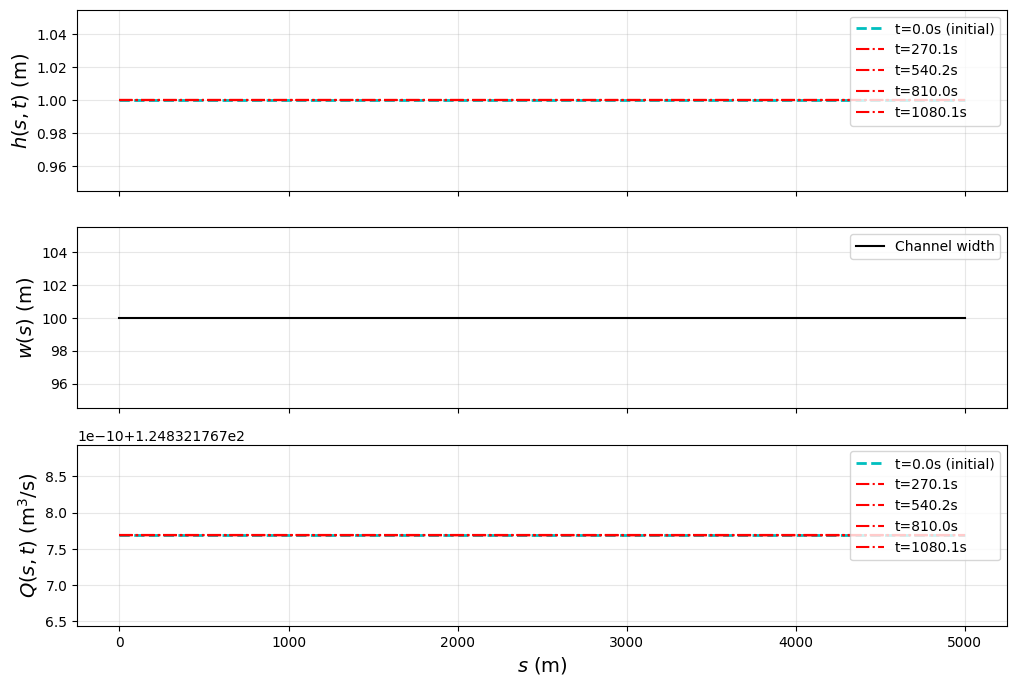

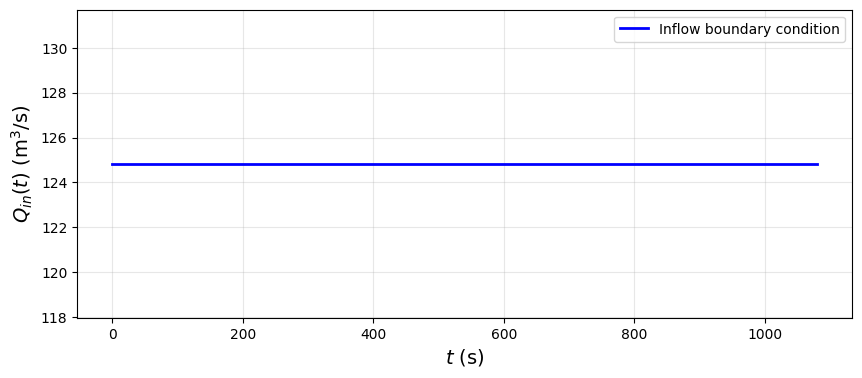

In [6]:
# Test Case 0: Rectangular channel with constant width 100m, constant height 1m and 
# constant inflow boundary condition
t_end = 3600 * 0.3
river_params_tc0 = RiverParameters(
    length=5000.0,
    num_cells=2500,
    w0=100.0,
    w1=100.0,
    w2=100.0,
    profile_type=0,  # Rectangular
    initial_depth=1
)

solver_params_tc0 = SolverParameters(
    t_end=t_end,
    CFL=0.5,
    Q_max=0.0,  # No pulse, constant inflow
    t_max=0.0,
    gamma=1.0,
    output_interval= t_end / 4
)

# Create river and solver instances
river_tc0 = River(river_params_tc0)
solver_tc0 = KinematicWaveSolver(river_tc0, solver_params_tc0)
solver_tc0.set_initial_condition()

# Create plotter instance
plotter_tc0 = RiverPlotter(solver_tc0)
# Plot callback defn
def plot_callback_tc0(t, nt):
    """Callback to plot at specific times."""
    print(f"Time step {nt}, t={t:.1f}s")
    plotter_tc0.plot_solution_at_time(color='r', linestyle='-.', show=False)
    
# Plot initial condition
plotter_tc0.plot_initial_condition(show=False)
plotter_tc0.plot_boundary_condition(show=False)

# Run simulation
solver_tc0.solve(callback=plot_callback_tc0)
print("Here")

Plotting solution at t=1080.11s


<Figure size 640x480 with 0 Axes>

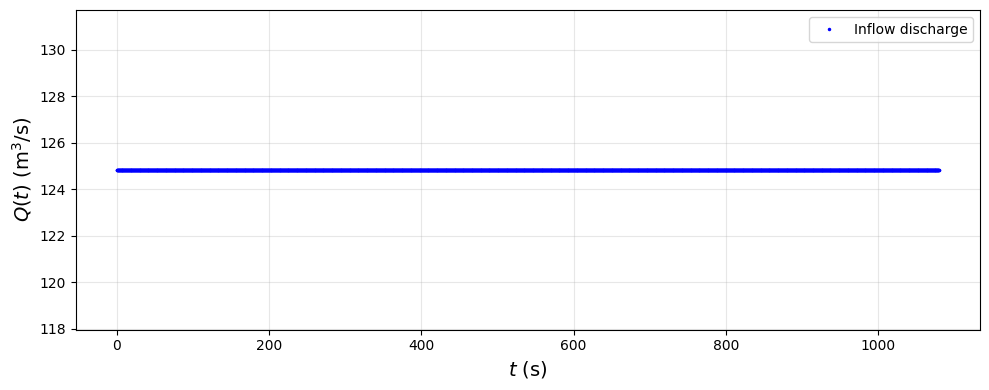

In [7]:
# Plot final solution
plotter_tc0.plot_final_solution(show=True)
# Plot inflow history
plotter_tc0.plot_inflow_history()
print()

In [8]:
# import pandas as pd

# solver_params_tc0.output_interval = t_end

# convergence: pd.DataFrame = convergence_test(river_params_tc0, solver_params_tc0, [1,2,4], [0.3, 0.5, 0.7], solver_params_tc0.t_end / 2)

## TC1

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Starting simulation: dt=0.4469855997698706s, t_end=10800s
Time step 3021, t=1350.3s
Plotting solution at t=1350.34s
Time step 6041, t=2700.2s
Plotting solution at t=2700.24s
Time step 9061, t=4050.1s
Plotting solution at t=4050.14s
Time step 12081, t=5400.0s
Plotting solution at t=5400.03s
Time step 15102, t=6750.4s
Plotting solution at t=6750.38s
Time step 18122, t=8100.3s
Plotting solution at t=8100.27s
Time step 21142, t=9450.2s
Plotting solution at t=9450.17s
Saving solution at t = 9720.0
Time step 24162, t=10800.1s
Plotting solution at t=10800.07s
Simulation complete: 24162 steps in 24.58s (0.41 min)



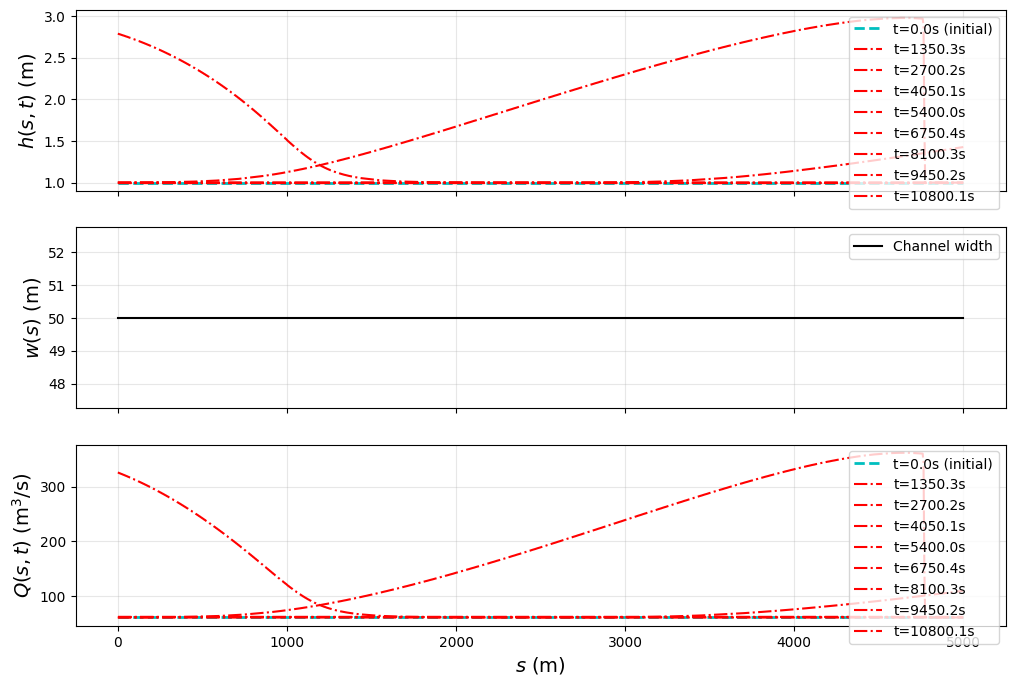

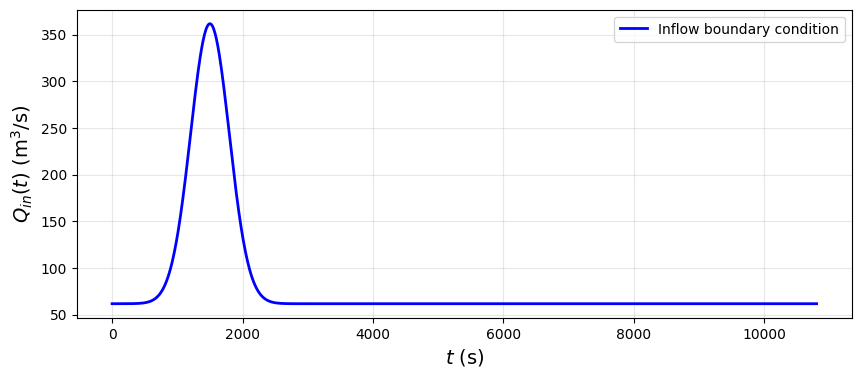

In [24]:
# Test Case 1: Rectangular channel with constant width but flood hydrograph at inflow
t_end = 3600 * 3
river_params_tc1 = RiverParameters(
    length=5000.0,
    num_cells=2500,
    w0=50.0,
    w1=50.0,
    w2=50.0,
    profile_type=0,  # Rectangular
    initial_depth=1
)
solver_params_tc1 = SolverParameters(
    t_end=t_end,
    CFL=0.7,
    Q_max=300.0,  # Pulse amplitude
    t_max=1500.0,  # Pulse peak time
    gamma=pulse_time_to_gamma(1800.0),  # Pulse decay rate for 30 min decay
    output_interval= t_end / 8,
    save_time = t_end * 9/10
)
# Create river and solver instances
river_tc1 = River(river_params_tc1)
solver_tc1 = KinematicWaveSolver(river_tc1, solver_params_tc1)
solver_tc1.set_initial_condition()
# Create plotter instance
plotter_tc1 = RiverPlotter(solver_tc1)
# Plot callback defn
def plot_callback_tc1(t, nt):
    """Callback to plot at specific times."""
    print(f"Time step {nt}, t={t:.1f}s")
    plotter_tc1.plot_solution_at_time(color='r', linestyle='-.', show=False)
# Plot initial condition
plotter_tc1.plot_initial_condition(show=False)
plotter_tc1.plot_boundary_condition(show=False)

# Run Simulation 
solver_tc1.solve(callback=plot_callback_tc1)

print()


Plotting solution at t=10800.07s


<Figure size 640x480 with 0 Axes>

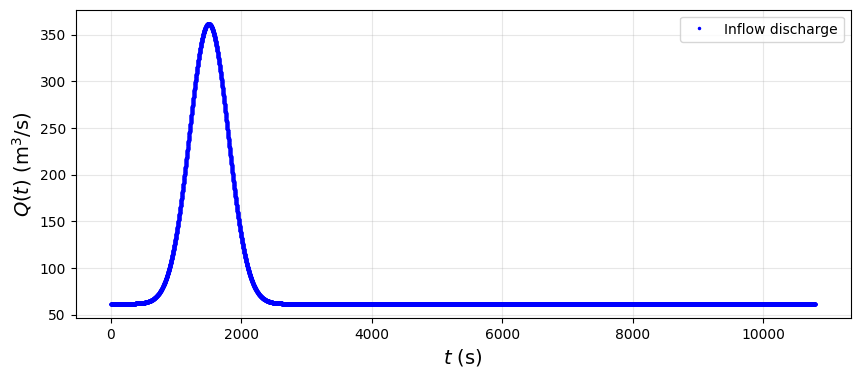

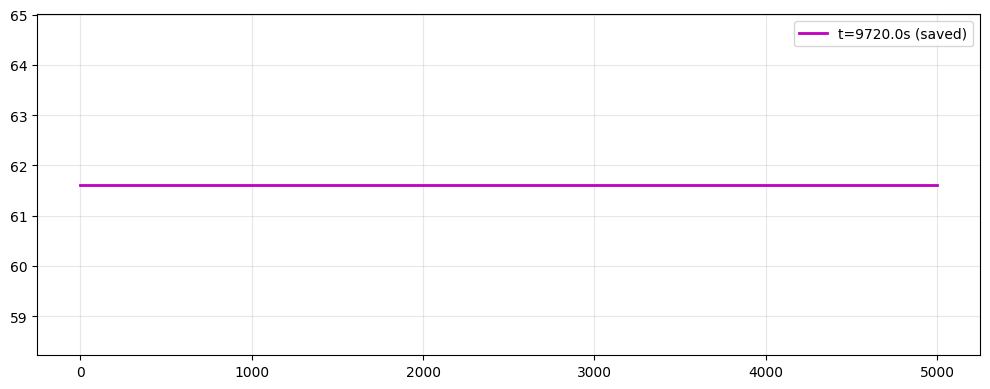

In [25]:
# Plot
plotter_tc1.plot_final_solution(show=True)
plotter_tc1.plot_inflow_history(show=False)
plotter_tc1.plot_saved_time(figsize=(10, 4))
print()

In [11]:
import pandas as pd

shock_capture = pd.DataFrame(columns=['Time (s)', 'Position (m)'])
data = [
    [2592, 4434],
    [2304, 3573],
    [2016, 2747],
]
shock_capture = pd.DataFrame(data, columns=['Time (s)', 'Position (m)'])

# Plot with plotly
import plotly.express as px
fig = px.scatter(shock_capture, x='Position (m)', y='Time (s)',
                 title='Shock Capture Data',
                 labels={'Time (s)': 'Time (s)', 'Position (m)': 'Position (m)'},
                 template='plotly_white')
fig.show()

# Calculate by comparing rows
shock_capture['Speed (m/s)'] = shock_capture['Position (m)'].diff() / shock_capture['Time (s)'].diff()
print(shock_capture)

   Time (s)  Position (m)  Speed (m/s)
0      2592          4434          NaN
1      2304          3573     2.989583
2      2016          2747     2.868056


In [12]:

# Convergence
solver_params_tc1.t_end = 3600 * 2
river_params_tc1.length = 2000
solver_params_tc1.output_interval = solver_params_tc1.t_end
convergence_tc1: pd.DataFrame = convergence_test(river_params_tc1, 
                                                 solver_params_tc1, 
                                                 [0.25, 0.5, 1, 1.5, 2,4, 8], 
                                                 [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
                                                 solver_params_tc1.t_end / 2,
                                                 show_plots=True)



Computing reference solution dt=0.4 dx=1.5003750937734435...
Starting simulation: dt=0.031927542840705044s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 225511 steps in 317.87s (5.30 min)
Reference solution computed. 

Computing reference solution dt=0.1 dx=1.5003750937734435...
Starting simulation: dt=0.04790329008357847s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 150303 steps in 121.26s (2.02 min)
Reference solution computed. 


Starting convergence tests dx...

Testing dx = 0.5 m with CFL = 0.4...
Starting simulation: dt=0.06385508568141009s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 112756 steps in 118.41s (1.97 min)

Testing dx = 1 m with CFL = 0.4...
Starting simulation: dt=0.12771017136282017s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 56378 steps in 48.74s (0.81 min)

Testing dx = 1.5 m with CFL = 0.4...
Starting simulation: dt=0.1916131603343139s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 37576 steps in 29.27s (0.49 min)

Testing dx = 2 m with CFL = 0.4...
Starting simulation: dt=0.25542034272564035s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 28189 steps in 21.15s (0.35 min)

Testing dx = 4 m with CFL = 0.4...
Starting simulation: dt=0.5108406854512807s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 14095 steps in 10.44s (0.17 min)

Testing dx = 8 m with CFL = 0.4...
Starting simulation: dt=1.0216813709025614s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 7048 steps in 5.47s (0.09 min)

Starting convergence tests cfl...

Testing CFL = 0.2 with dx = 1.5 m...
Starting simulation: dt=0.09580658016715694s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 75152 steps in 58.31s (0.97 min)

Testing CFL = 0.3 with dx = 1.5 m...
Starting simulation: dt=0.1437098702507354s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 50101 steps in 39.76s (0.66 min)

Testing CFL = 0.4 with dx = 1.5 m...
Starting simulation: dt=0.1916131603343139s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 37576 steps in 29.40s (0.49 min)

Testing CFL = 0.5 with dx = 1.5 m...
Starting simulation: dt=0.23951645041789232s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 30061 steps in 23.92s (0.40 min)

Testing CFL = 0.6 with dx = 1.5 m...
Starting simulation: dt=0.2874197405014708s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 25051 steps in 20.03s (0.33 min)

Testing CFL = 0.7 with dx = 1.5 m...
Starting simulation: dt=0.33532303058504925s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 21472 steps in 16.70s (0.28 min)



In [13]:
# Take sums of each error column in convergence_tc1 dataframe to see overall error levels
def aggregate_error_values(convergence_data: pd.DataFrame) -> dict:
    error_summaries = {}
    for col in convergence_data.columns:
        if 'error' in col:
            error_summaries[col] = float(convergence_data[col].sum())
    return error_summaries

error_summaries = aggregate_error_values(convergence_tc1)
error_summaries

{'error_dx - 0.5 - 0.4': 0.002511503755233468,
 'error_dx - 1 - 0.4': 0.007435718915364531,
 'error_dx - 1.5 - 0.4': 0.013385011917177872,
 'error_dx - 2 - 0.4': 0.01682878568968895,
 'error_dx - 4 - 0.4': 0.038698892343542846,
 'error_dx - 8 - 0.4': 0.08886149447861938,
 'error_cfl - 0.2 - 1.5': 0.0010192749269492157,
 'error_cfl - 0.3 - 1.5': 0.0022533238191986076,
 'error_cfl - 0.4 - 1.5': 0.0030511125818356187,
 'error_cfl - 0.5 - 1.5': 0.004711144113304,
 'error_cfl - 0.6 - 1.5': 0.0059349245952910025,
 'error_cfl - 0.7 - 1.5': 0.006082110372132884}

## TC2ab

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Starting simulation: dt=0.4469855997698706s, t_end=2880.0s
Time step 1074, t=480.1s
Plotting solution at t=480.06s


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Time step 2148, t=960.1s
Plotting solution at t=960.13s
Time step 3222, t=1440.2s
Plotting solution at t=1440.19s
Time step 4296, t=1920.3s
Plotting solution at t=1920.25s
Time step 5370, t=2400.3s
Plotting solution at t=2400.31s
Saving solution at t = 2448.0
Time step 6444, t=2880.4s
Plotting solution at t=2880.38s
Simulation complete: 6444 steps in 8.56s (0.14 min)


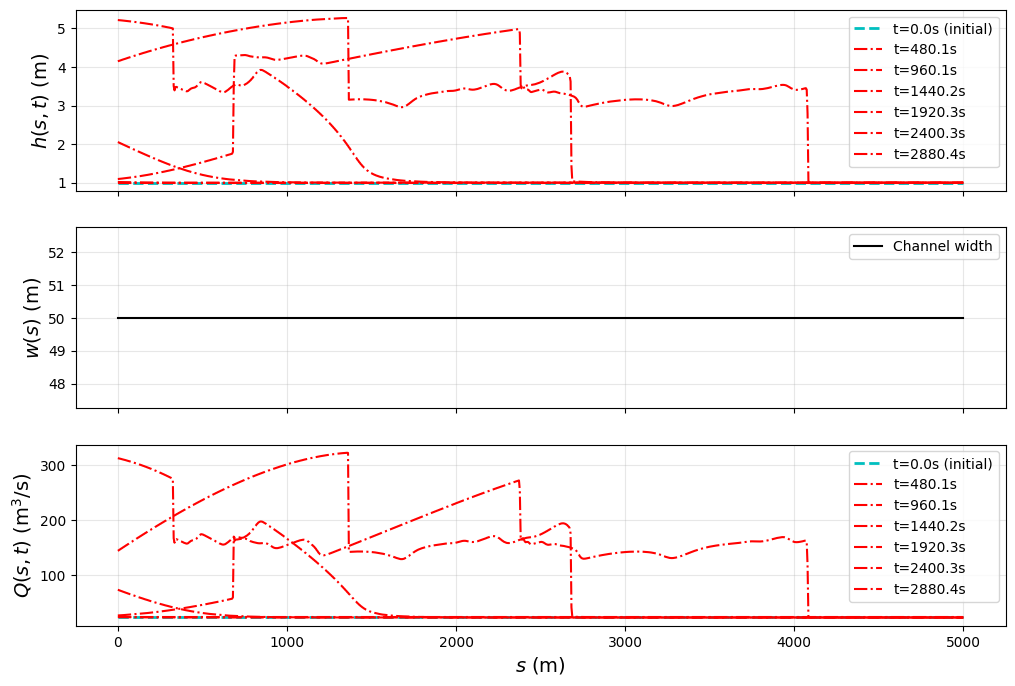

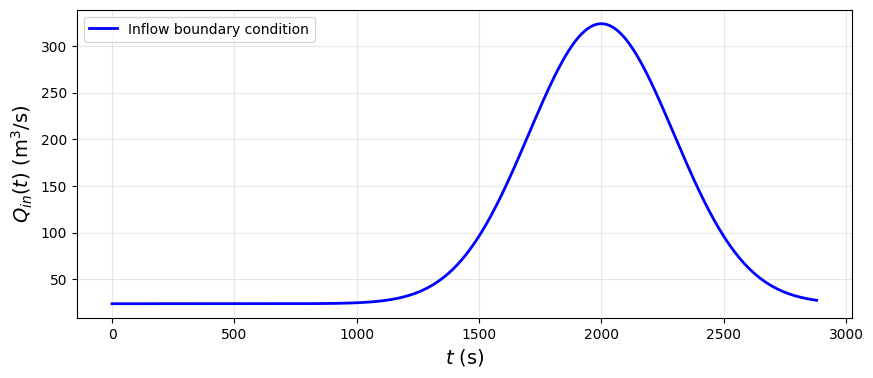

In [14]:
# Test Case 2ab: Compound channel with constant width and flood hydrograph at inflow
t_end = 3600 * 0.8
river_params_tc2 = RiverParameters(
    length=5000.0,
    num_cells=2500,
    w0=50.0,
    w1=50.0,
    w2=50.0,
    profile_type=1,  # Compound
    wb=20.0,
    hb=4.0,
    initial_depth=1
)
solver_params_tc2 = SolverParameters(
    t_end=t_end,
    CFL=0.7,
    Q_max=300.0,  # Pulse amplitude
    t_max=2000.0,  # Pulse peak time
    gamma=pulse_time_to_gamma(1800.0),  # Pulse decay rate for 30 min decay
    output_interval= t_end / 6,
    save_time = t_end * 8.5/10
)
# Create river and solver instances
river_tc2 = River(river_params_tc2)
solver_tc2 = KinematicWaveSolver(river_tc2, solver_params_tc2)
solver_tc2.set_initial_condition()
# Create plotter instance
plotter_tc2 = RiverPlotter(solver_tc2)
# Plot callback defn
def plot_callback_tc2(t, nt):
    """Callback to plot at specific times."""
    print(f"Time step {nt}, t={t:.1f}s")
    plotter_tc2.plot_solution_at_time(color='r', linestyle='-.', show=False)
# Plot initial condition
plotter_tc2.plot_initial_condition(show=False)
plotter_tc2.plot_boundary_condition(show=False)

# Run Simulation
solver_tc2.solve(callback=plot_callback_tc2)

Plotting solution at t=2880.38s


<Figure size 640x480 with 0 Axes>

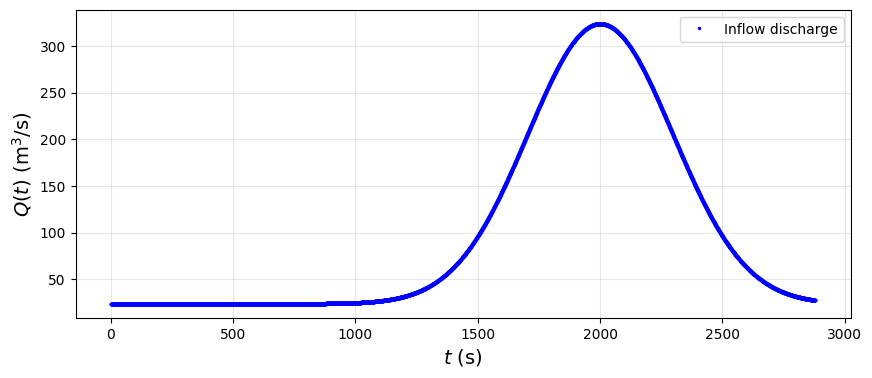

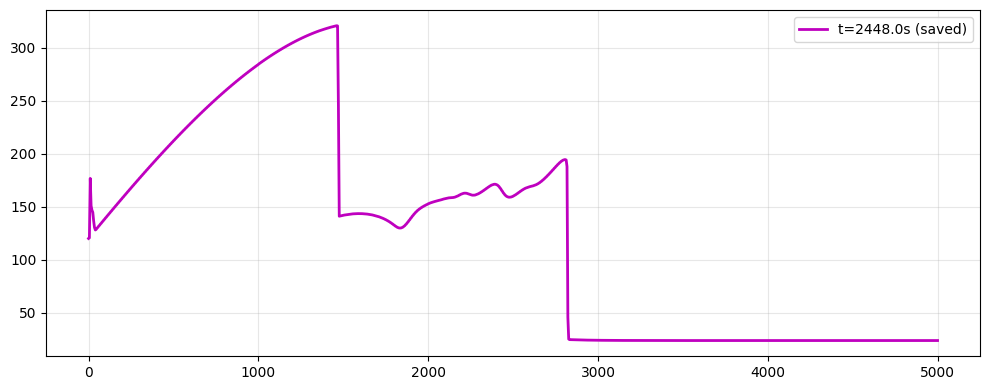

In [15]:
# Plot 
plotter_tc2.plot_final_solution(show=True)
plotter_tc2.plot_inflow_history(show=False)
print()

plotter_tc2.plot_saved_time(figsize=(10, 4))

In [16]:
import pandas as pd
import plotly.express as px

shock_capture_tc2 = pd.DataFrame(columns=['Time (s)', 'Position 1 (m)', 'Position 2 (m)'])
data_tc2 = [
    [2592, 1791, 3243],
    [2736, 2097, 3658],
    [2448, 1466, 2817]
]
shock_capture_tc2 = pd.DataFrame(data_tc2, columns=['Time (s)', 'Position 1 (m)', 'Position 2 (m)'])
# Calculate the shock speed for shocks 1 and 2
shock_speeds_tc2 = []

# Plot the values of shock positions over time
fig = px.scatter(shock_capture_tc2, x='Time (s)', y=['Position 1 (m)', 'Position 2 (m)'],
                 title='Shock Positions Over Time',
                 labels={'value': 'Position (m)', 'Time (s)': 'Time (s)'},
                 template='plotly_white')
fig.show()
# Calculate speeds
shock_1_speeds = [
    (data_tc2[i][1] - data_tc2[i-1][1]) / (data_tc2[i][0] - data_tc2[i-1][0])
    for i in range(1, len(data_tc2))
]
print("Shock 1 Speeds (m/s):", shock_1_speeds)
shock_2_speeds = [
    (data_tc2[i][2] - data_tc2[i-1][2]) / (data_tc2[i][0] - data_tc2[i-1][0])
    for i in range(1, len(data_tc2))
]
print("Shock 2 Speeds (m/s):", shock_2_speeds)
    

Shock 1 Speeds (m/s): [2.125, 2.1909722222222223]
Shock 2 Speeds (m/s): [2.8819444444444446, 2.920138888888889]


In [17]:
# Convergence 
solver_params_tc2.t_end = 3600 * 2
river_params_tc2.length = 2000
solver_params_tc2.output_interval = solver_params_tc2.t_end
convergence_tc2: pd.DataFrame = convergence_test(river_params_tc2, 
                                                 solver_params_tc2, 
                                                 [0.25, 0.5, 1, 1.5, 2,4, 8], 
                                                 [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
                                                 solver_params_tc2.t_end / 2,
                                                 show_plots=True)

Computing reference solution dt=0.4 dx=1.5003750937734435...
Starting simulation: dt=0.031927542840705044s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 225511 steps in 315.30s (5.26 min)
Reference solution computed. 

Computing reference solution dt=0.1 dx=1.5003750937734435...
Starting simulation: dt=0.04790329008357847s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 150303 steps in 116.62s (1.94 min)
Reference solution computed. 


Starting convergence tests dx...

Testing dx = 0.5 m with CFL = 0.4...
Starting simulation: dt=0.06385508568141009s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 112756 steps in 116.48s (1.94 min)

Testing dx = 1 m with CFL = 0.4...
Starting simulation: dt=0.12771017136282017s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 56378 steps in 47.95s (0.80 min)

Testing dx = 1.5 m with CFL = 0.4...
Starting simulation: dt=0.1916131603343139s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 37576 steps in 29.93s (0.50 min)

Testing dx = 2 m with CFL = 0.4...
Starting simulation: dt=0.25542034272564035s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 28189 steps in 21.86s (0.36 min)

Testing dx = 4 m with CFL = 0.4...
Starting simulation: dt=0.5108406854512807s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 14095 steps in 10.73s (0.18 min)

Testing dx = 8 m with CFL = 0.4...
Starting simulation: dt=1.0216813709025614s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 7048 steps in 5.56s (0.09 min)

Starting convergence tests cfl...

Testing CFL = 0.2 with dx = 1.5 m...
Starting simulation: dt=0.09580658016715694s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 75152 steps in 59.17s (0.99 min)

Testing CFL = 0.3 with dx = 1.5 m...
Starting simulation: dt=0.1437098702507354s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 50101 steps in 38.89s (0.65 min)

Testing CFL = 0.4 with dx = 1.5 m...
Starting simulation: dt=0.1916131603343139s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 37576 steps in 29.00s (0.48 min)

Testing CFL = 0.5 with dx = 1.5 m...
Starting simulation: dt=0.23951645041789232s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 30061 steps in 22.88s (0.38 min)

Testing CFL = 0.6 with dx = 1.5 m...
Starting simulation: dt=0.2874197405014708s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 25051 steps in 19.19s (0.32 min)

Testing CFL = 0.7 with dx = 1.5 m...
Starting simulation: dt=0.33532303058504925s, t_end=7200s
Saving solution at t = 3600.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



Simulation complete: 21472 steps in 16.48s (0.27 min)



In [18]:
# Summarize
error_summaries_tc2 = aggregate_error_values(convergence_tc2)
error_summaries_tc2

{'error_dx - 0.5 - 0.4': 0.2963413004106066,
 'error_dx - 1 - 0.4': 0.9412047436596495,
 'error_dx - 1.5 - 0.4': 1.7660427964955185,
 'error_dx - 2 - 0.4': 2.24423680280682,
 'error_dx - 4 - 0.4': 4.521962210853762,
 'error_dx - 8 - 0.4': 9.455513609417643,
 'error_cfl - 0.2 - 1.5': 3.8829115578235536,
 'error_cfl - 0.3 - 1.5': 7.099668522786145,
 'error_cfl - 0.4 - 1.5': 13.396715450238297,
 'error_cfl - 0.5 - 1.5': 16.524308075894027,
 'error_cfl - 0.6 - 1.5': 12.231436614542103,
 'error_cfl - 0.7 - 1.5': 28.482960385516794}

## Convergence: TC2

In [19]:
# Save data to csv
convergence_tc1.to_csv('convergence_tc1.csv', index=False)
convergence_tc2.to_csv('convergence_tc2.csv', index=False)

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning:

The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.



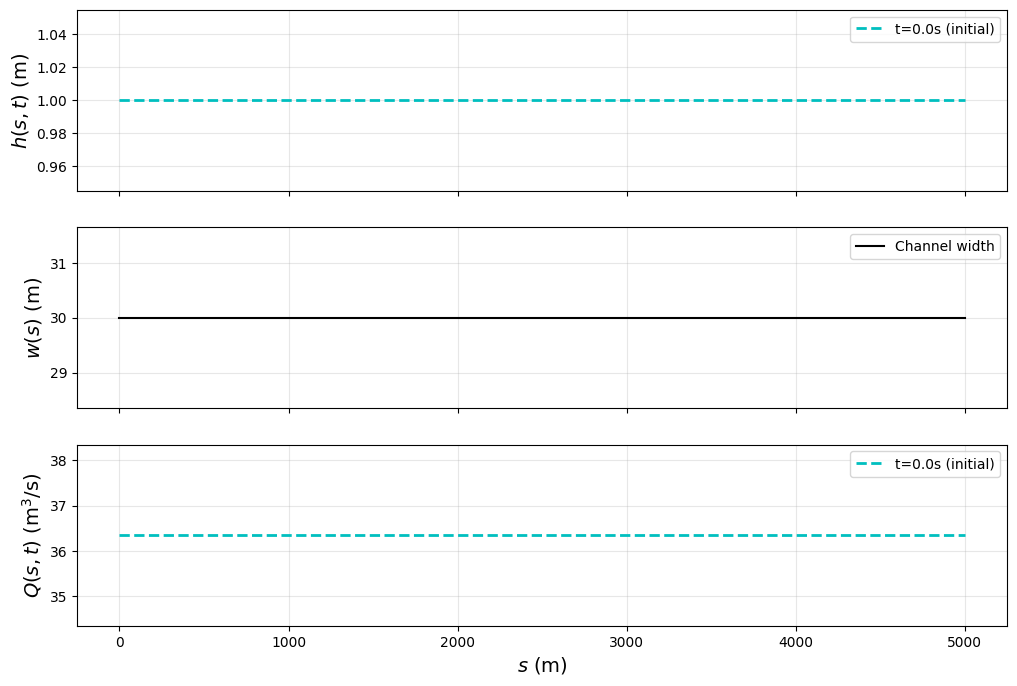

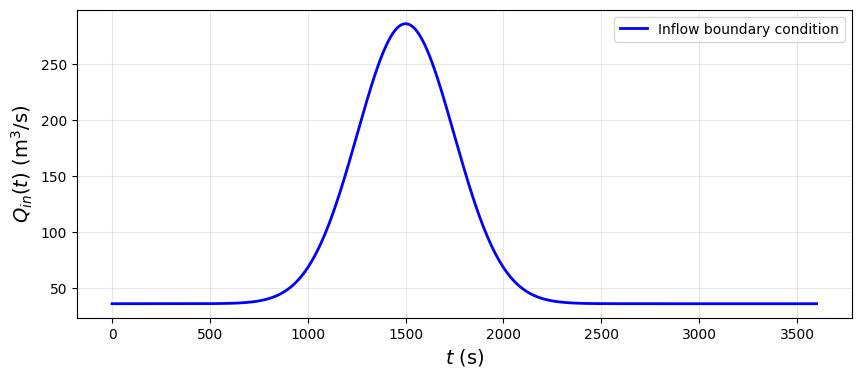

In [20]:
# Create river with rectangular profile
river_params_rect = RiverParameters(
    length=5000.0,
    num_cells=2500,
    w0=30.0,
    w1=30.0,
    w2=30.0,
    profile_type=0,  # Rectangular
    initial_depth=1
)

river_rect = River(river_params_rect)

# Create solver
t_end = 3600 * 1
solver_params_rect = SolverParameters(
    t_end=t_end,
    CFL=0.5,
    Q_max=250.0,
    t_max=1500,
    gamma=pulse_time_to_gamma(1500),
    output_interval=t_end / 8
)

solver_rect = KinematicWaveSolver(river_rect, solver_params_rect)
solver_rect.set_initial_condition()

# Create plotter
plotter_rect = RiverPlotter(solver_rect)

# Plot initial condition
plotter_rect.plot_initial_condition(show=False)
plotter_rect.plot_boundary_condition(show=False)
print()

In [21]:
# Run simulation with intermediate plotting

solver_rect.solve(callback=plot_callback)

# Plot final solution
plotter_rect.plot_final_solution(show=True)

NameError: name 'plot_callback' is not defined

In [ ]:
import pandas as pd

def check_convergence(river: River, base_solver_params: SolverParameters, 
                      CFL_values: list[float]) -> pd.DataFrame:
    # Create solver params for each of the cfl values
    solvers = []
    for CFL in CFL_values:
        solver_params = SolverParameters(
            t_end=base_solver_params.t_end,
            CFL=CFL,
            Q_max=base_solver_params.Q_max,
            t_max=base_solver_params.t_max,
            gamma=base_solver_params.gamma,
            output_interval=base_solver_params.output_interval
        )
        solver = KinematicWaveSolver(river, solver_params)
        solver.set_initial_condition()
        solvers.append(solver)

    # Run simulations
    for solver in solvers:
        solver.solve()
    
    # Create data frame of saved data time for each of the different cfl values
    data = {}
    for CFL, solver in zip(CFL_values, solvers):
        saved_data = solver.data_at_save
        if saved_data is not None:
            x_vals, width_vals, depth_vals, discharge_vals = saved_data
            data[f'CFL={CFL}'] = discharge_vals
    df = pd.DataFrame(data, index=x_vals)
    print(df)
    return df

base_solver_params = SolverParameters(
    t_end=t_end,
    CFL=0.5,
    Q_max=250.0,
    t_max=1500,
    gamma=pulse_time_to_gamma(1500),
    output_interval=t_end / 8
)
river = river_rect
CFL_values = [0.3, 0.5, 0.7]
df_convergence = check_convergence(river, base_solver_params, CFL_values)

Starting simulation: dt=0.19156525704423027s, t_end=3600s
Saving solution at t = 1800.0


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Simulation complete: 18793 steps in 18.16s (0.30 min)
Starting simulation: dt=0.3192754284070505s, t_end=3600s
Saving solution at t = 1800.0
Simulation complete: 11276 steps in 10.90s (0.18 min)
Starting simulation: dt=0.4469855997698706s, t_end=3600s
Saving solution at t = 1800.0
Simulation complete: 8054 steps in 8.03s (0.13 min)
                CFL=0.3     CFL=0.5     CFL=0.7
0.000001     156.394706  156.507345  156.620018
5.005006     157.107844  157.220513  157.333214
10.010011    158.176010  158.288720  158.401464
15.015016    158.887073  158.999810  159.112580
20.020021    159.952063  160.064839  160.177648
...                 ...         ...         ...
4979.979979   36.349248   36.349248   36.349248
4984.984984   36.349248   36.349248   36.349248
4989.989989   36.349248   36.349248   36.349248
4994.994994   36.349248   36.349248   36.349248
4999.999999   36.349248   36.349248   36.349248

[1000 rows x 3 columns]


In [ ]:
CFL_alternation

NameError: name 'CFL_alternation' is not defined

### Compound Channel (nRP=1)

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


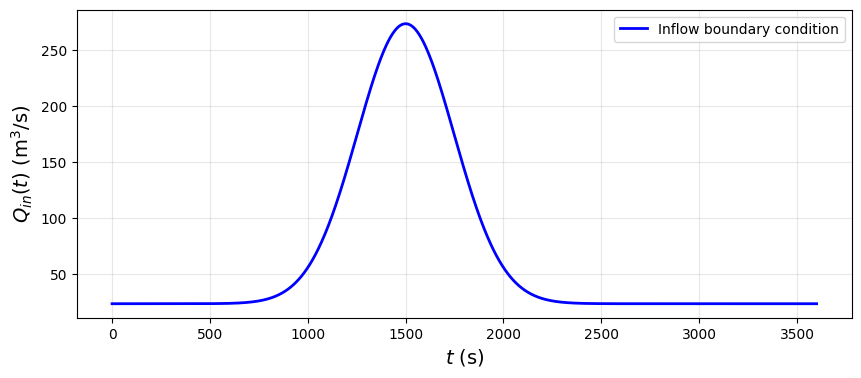

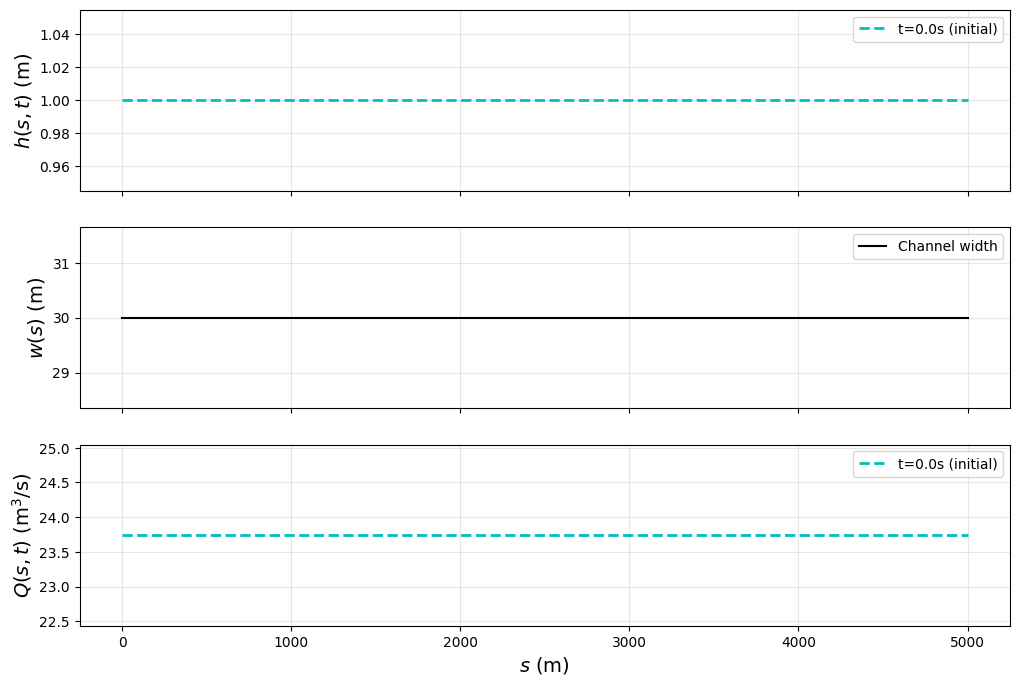

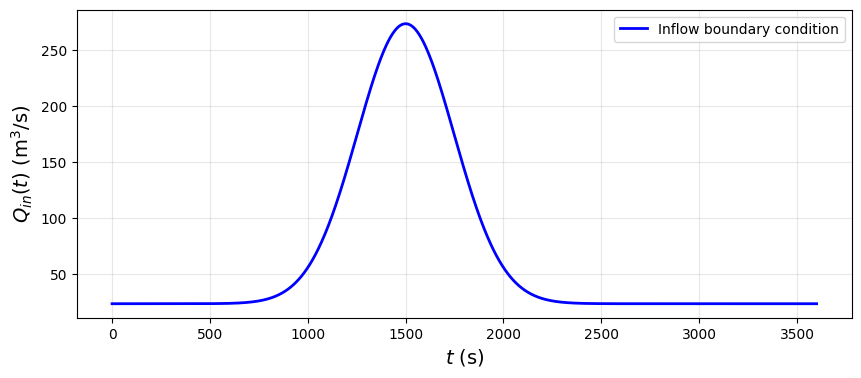

In [ ]:
# Create river with compound channel profile
river_params_compound = RiverParameters(
    length=5000.0,
    num_cells=2500,
    w0=30.0,
    w1=30.0,
    w2=30.0,
    profile_type=1,  # Compound channel
    wb=20.0,         # Narrow width
    hb=5.0,          # Narrow height
    initial_depth=1
)

river_compound = River(river_params_compound)

# Create solver
solver_params_compound = SolverParameters(
    t_end=t_end,
    CFL=0.5,
    Q_max=250.0,
    t_max=1500,
    gamma=pulse_time_to_gamma(1500),
    output_interval=t_end / 8
)
solver_compound = KinematicWaveSolver(river_compound, solver_params_compound)
solver_compound.set_initial_condition()

# Create plotter
plotter_compound = RiverPlotter(solver_compound)
# Plot initial condition
plotter_compound.plot_initial_condition(show=False)
plotter_compound.plot_boundary_condition(show=False)

Starting simulation: dt=0.3192754284070505s, t_end=3600s
Time step 1410, t=450.2s
Plotting solution at t=450.18s
Time step 2819, t=900.0s
Plotting solution at t=900.04s
Time step 4229, t=1350.2s
Plotting solution at t=1350.22s
Time step 5638, t=1800.1s
Plotting solution at t=1800.07s
Time step 7048, t=2250.3s
Plotting solution at t=2250.25s
Time step 8457, t=2700.1s
Plotting solution at t=2700.11s
Time step 9867, t=3150.3s
Plotting solution at t=3150.29s
Time step 11276, t=3600.1s
Plotting solution at t=3600.15s
Simulation complete: 11276 steps in 13.94s (0.23 min)
Plotting solution at t=3600.15s


<Figure size 640x480 with 0 Axes>

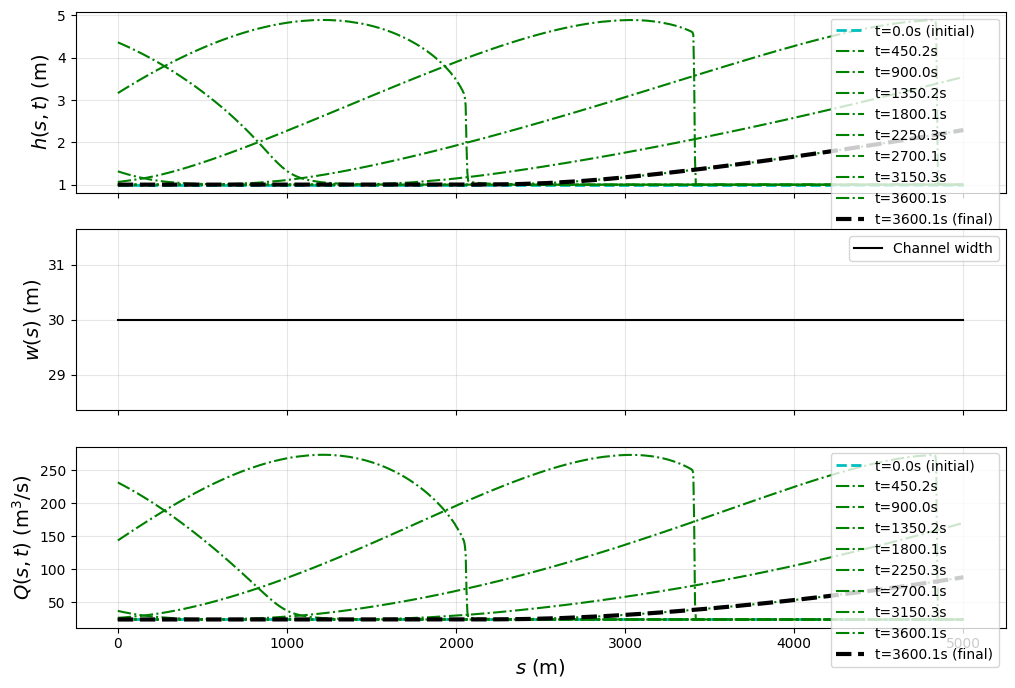

In [ ]:
# Run simulation with intermediate plotting
def plot_callback_compound(t, nt):
    """Callback to plot at specific times."""
    print(f"Time step {nt}, t={t:.1f}s")
    plotter_compound.plot_solution_at_time(color='g', linestyle='-.', show=False)

solver_compound.solve(callback=plot_callback_compound)

# Plot final solution
plotter_compound.plot_final_solution(show=True)

In [ ]:
# Plot inflow discharge history
plotter_compound.plot_inflow_history()

## Custom Simulation Example

Example showing how to plot at specific times of interest.

In [ ]:
# Create a custom simulation with specific output times
river_custom = River(RiverParameters(
    length=5000.0,
    num_cells=2500,
    profile_type=1,
    wb=20.0,
    hb=5.0,
    initial_depth=0.05
))

solver_custom = KinematicWaveSolver(river_custom, SolverParameters(
    dt=0.5,
    t_end=100.0,
    Q_max=300.0,
    t_max=25.0,
    output_interval=5.0  # Output every 5 seconds
))

solver_custom.set_initial_condition()
plotter_custom = RiverPlotter(solver_custom)

# Plot initial condition
plotter_custom.plot_initial_condition(show=False)

# Define specific times to highlight
highlight_times = [20.0, 40.0, 60.0, 80.0, 100.0]
colors = ['orange', 'purple', 'brown', 'pink', 'navy']

def custom_callback(t, nt):
    # Check if current time is close to a highlight time
    for highlight_t, color in zip(highlight_times, colors):
        if abs(t - highlight_t) < 0.6:  # Within dt
            print(f"Plotting at t={t:.1f}s (highlight)")
            plotter_custom.plot_solution_at_time(
                color=color, 
                linestyle='-', 
                linewidth=2,
                label=f't={highlight_t:.0f}s',
                show=False
            )
            return

# Run simulation
solver_custom.solve(callback=custom_callback)

# Plot final
plotter_custom.plot_final_solution(show=True)

# Save figure
plotter_custom.save_profile_figure('custom_simulation.png')

In [ ]:
# Plot inflow history for custom simulation
plotter_custom.plot_inflow_history()